This notebook shows data exploration and preprocessing. It is our first step before running models on the preprocessed data.

In [1]:
# in order to work with arff files we have to install 'liac-arff' - if first usage: uncomment code cell below and run
# pip install liac-arff

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# basic packages
import arff
import numpy as np
import pandas as pd

# packages for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# package for balancing
from imblearn.over_sampling import RandomOverSampler

# package for preprocessing
from sklearn import preprocessing

# import functions from other notebooks
from ipynb.fs.full.Functions import load_train_test_data

# 1) Data Loading & First Insights

In [4]:
# import data
data = arff.load(open('data/diabetes_dataset.arff', 'r'))

In [5]:
df_header = list(pd.DataFrame(data['attributes'])[0])
df_header

['Age',
 'Gender',
 'Family_Diabetes',
 'highBP',
 'PhysicallyActive',
 'BMI',
 'Smoking',
 'Alcohol',
 'Sleep',
 'SoundSleep',
 'RegularMedicine',
 'JunkFood',
 'Stress',
 'BPLevel',
 'Pregancies',
 'Pdiabetes',
 'UriationFreq',
 'Diabetic']

In [6]:
# change faulty header 'Pregancies' into 'Pregnancies' and 'UriationFreq' into 'UrinationFreq'
df_header[14] = 'Pregnancies'
df_header[16] = 'UrinationFreq'
df_header

['Age',
 'Gender',
 'Family_Diabetes',
 'highBP',
 'PhysicallyActive',
 'BMI',
 'Smoking',
 'Alcohol',
 'Sleep',
 'SoundSleep',
 'RegularMedicine',
 'JunkFood',
 'Stress',
 'BPLevel',
 'Pregnancies',
 'Pdiabetes',
 'UrinationFreq',
 'Diabetic']

In [7]:
# convert arff data into a pandas dataframe
df = pd.DataFrame(data['data'], columns=df_header)
df.head()

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,Pdiabetes,UrinationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no


In [8]:
# print main information about data
print("There are {} entries with {} columns including the target variable 'Diabetic'.".format(df.shape[0], df.shape[1]))

There are 952 entries with 18 columns including the target variable 'Diabetic'.


In [9]:
# check for missing values
display(df.isnull().sum())
print("There are {} missing values.".format(df.isnull().sum().sum()))

Age                  0
Gender               0
Family_Diabetes      0
highBP               0
PhysicallyActive     0
BMI                  4
Smoking              0
Alcohol              0
Sleep                0
SoundSleep           0
RegularMedicine      0
JunkFood             0
Stress               0
BPLevel              0
Pregnancies         42
Pdiabetes            1
UrinationFreq        0
Diabetic             1
dtype: int64

There are 48 missing values.


There are a few missing values. Empty answers in pregnancies could be seen as 0 pregnancies. Nonetheless, we are not completely sure about this. Therefore, in order to have better explanation of feature importance in the end and in order to train our models in the best possible way, we discard the entries with missing values. It will change the number of entries only slightly.

In [10]:
# drop rows with missing values
df.dropna(inplace=True)

# again print main information about data
print("There are {} entries with {} columns including the target variable 'Diabetic'.".format(df.shape[0], df.shape[1]))

There are 905 entries with 18 columns including the target variable 'Diabetic'.


In [11]:
# check for duplicates
print("There are {} duplicated entries.".format(df.duplicated().sum()))

There are 622 duplicated entries.


This is somehow expected in this dataset. The data has been achieved by a survey where individual people answered a questionnaire. Because of that, it is usual to see similar or also same entries for different persons. 

In [12]:
# now let's have a closer look at the target data
df['Diabetic'].unique()

array(['no', 'yes', ' no'], dtype=object)

We can see that there are some faulty data in the dataset in regards to our target variable. We have the class label ' no' which is probably due to incorrect recording. We will change these to 'no'.

In [13]:
df.loc[df['Diabetic']==' no', 'Diabetic'] = 'no'

In [14]:
# check if it worked
df['Diabetic'].unique()

array(['no', 'yes'], dtype=object)

In [15]:
# check types of columns and convert them into useful types according to their meaning afterwards
df.dtypes

Age                  object
Gender               object
Family_Diabetes      object
highBP               object
PhysicallyActive     object
BMI                 float64
Smoking              object
Alcohol              object
Sleep                 int64
SoundSleep            int64
RegularMedicine      object
JunkFood             object
Stress               object
BPLevel              object
Pregnancies         float64
Pdiabetes            object
UrinationFreq        object
Diabetic             object
dtype: object

In general, we have a lot of categorical variables. For most of them this is expected. Nonetheless, for 'Age' we ususally would have expected numerical values but it has already been binned into categories like '40-49'. We will see how useful the bins are for the models later on. Other categorical features like 'Gender' or 'Family_Diabetes' only have two possible labels. We can change them later into numerical ones in our preprocessing. Moreover, there are some numerical values as well such as 'BMI', 'Sleep', or 'Pregnancies'. We'll have a closer look at each of them later for preprocessing.  Let's first visualize them before further preprocessing. 

# 2) First Data Visualization (Univariate Analysis)

In [16]:
# define a distribution graph (histogram/bar graph) for the different columns
def plotDistributions(df, nGraphs, nGraphsPerRow):
    nrows, ncols = df.shape
    nGraphRow = (ncols + nGraphsPerRow - 1) / nGraphsPerRow
    plt.figure(num = None, figsize = (6 * nGraphsPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    
    for i in range(min(ncols, nGraphs)):
        plt.subplot(nGraphRow, nGraphsPerRow, i + 1)
        columnDf = df.iloc[:, i]
        
        # check if type in column in object or number
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)): 
            # do value counts a bar plot for categorical features
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            # do histogram for numerical features
            columnDf.hist()
            
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{df_header[i]} (column {i})')
        
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

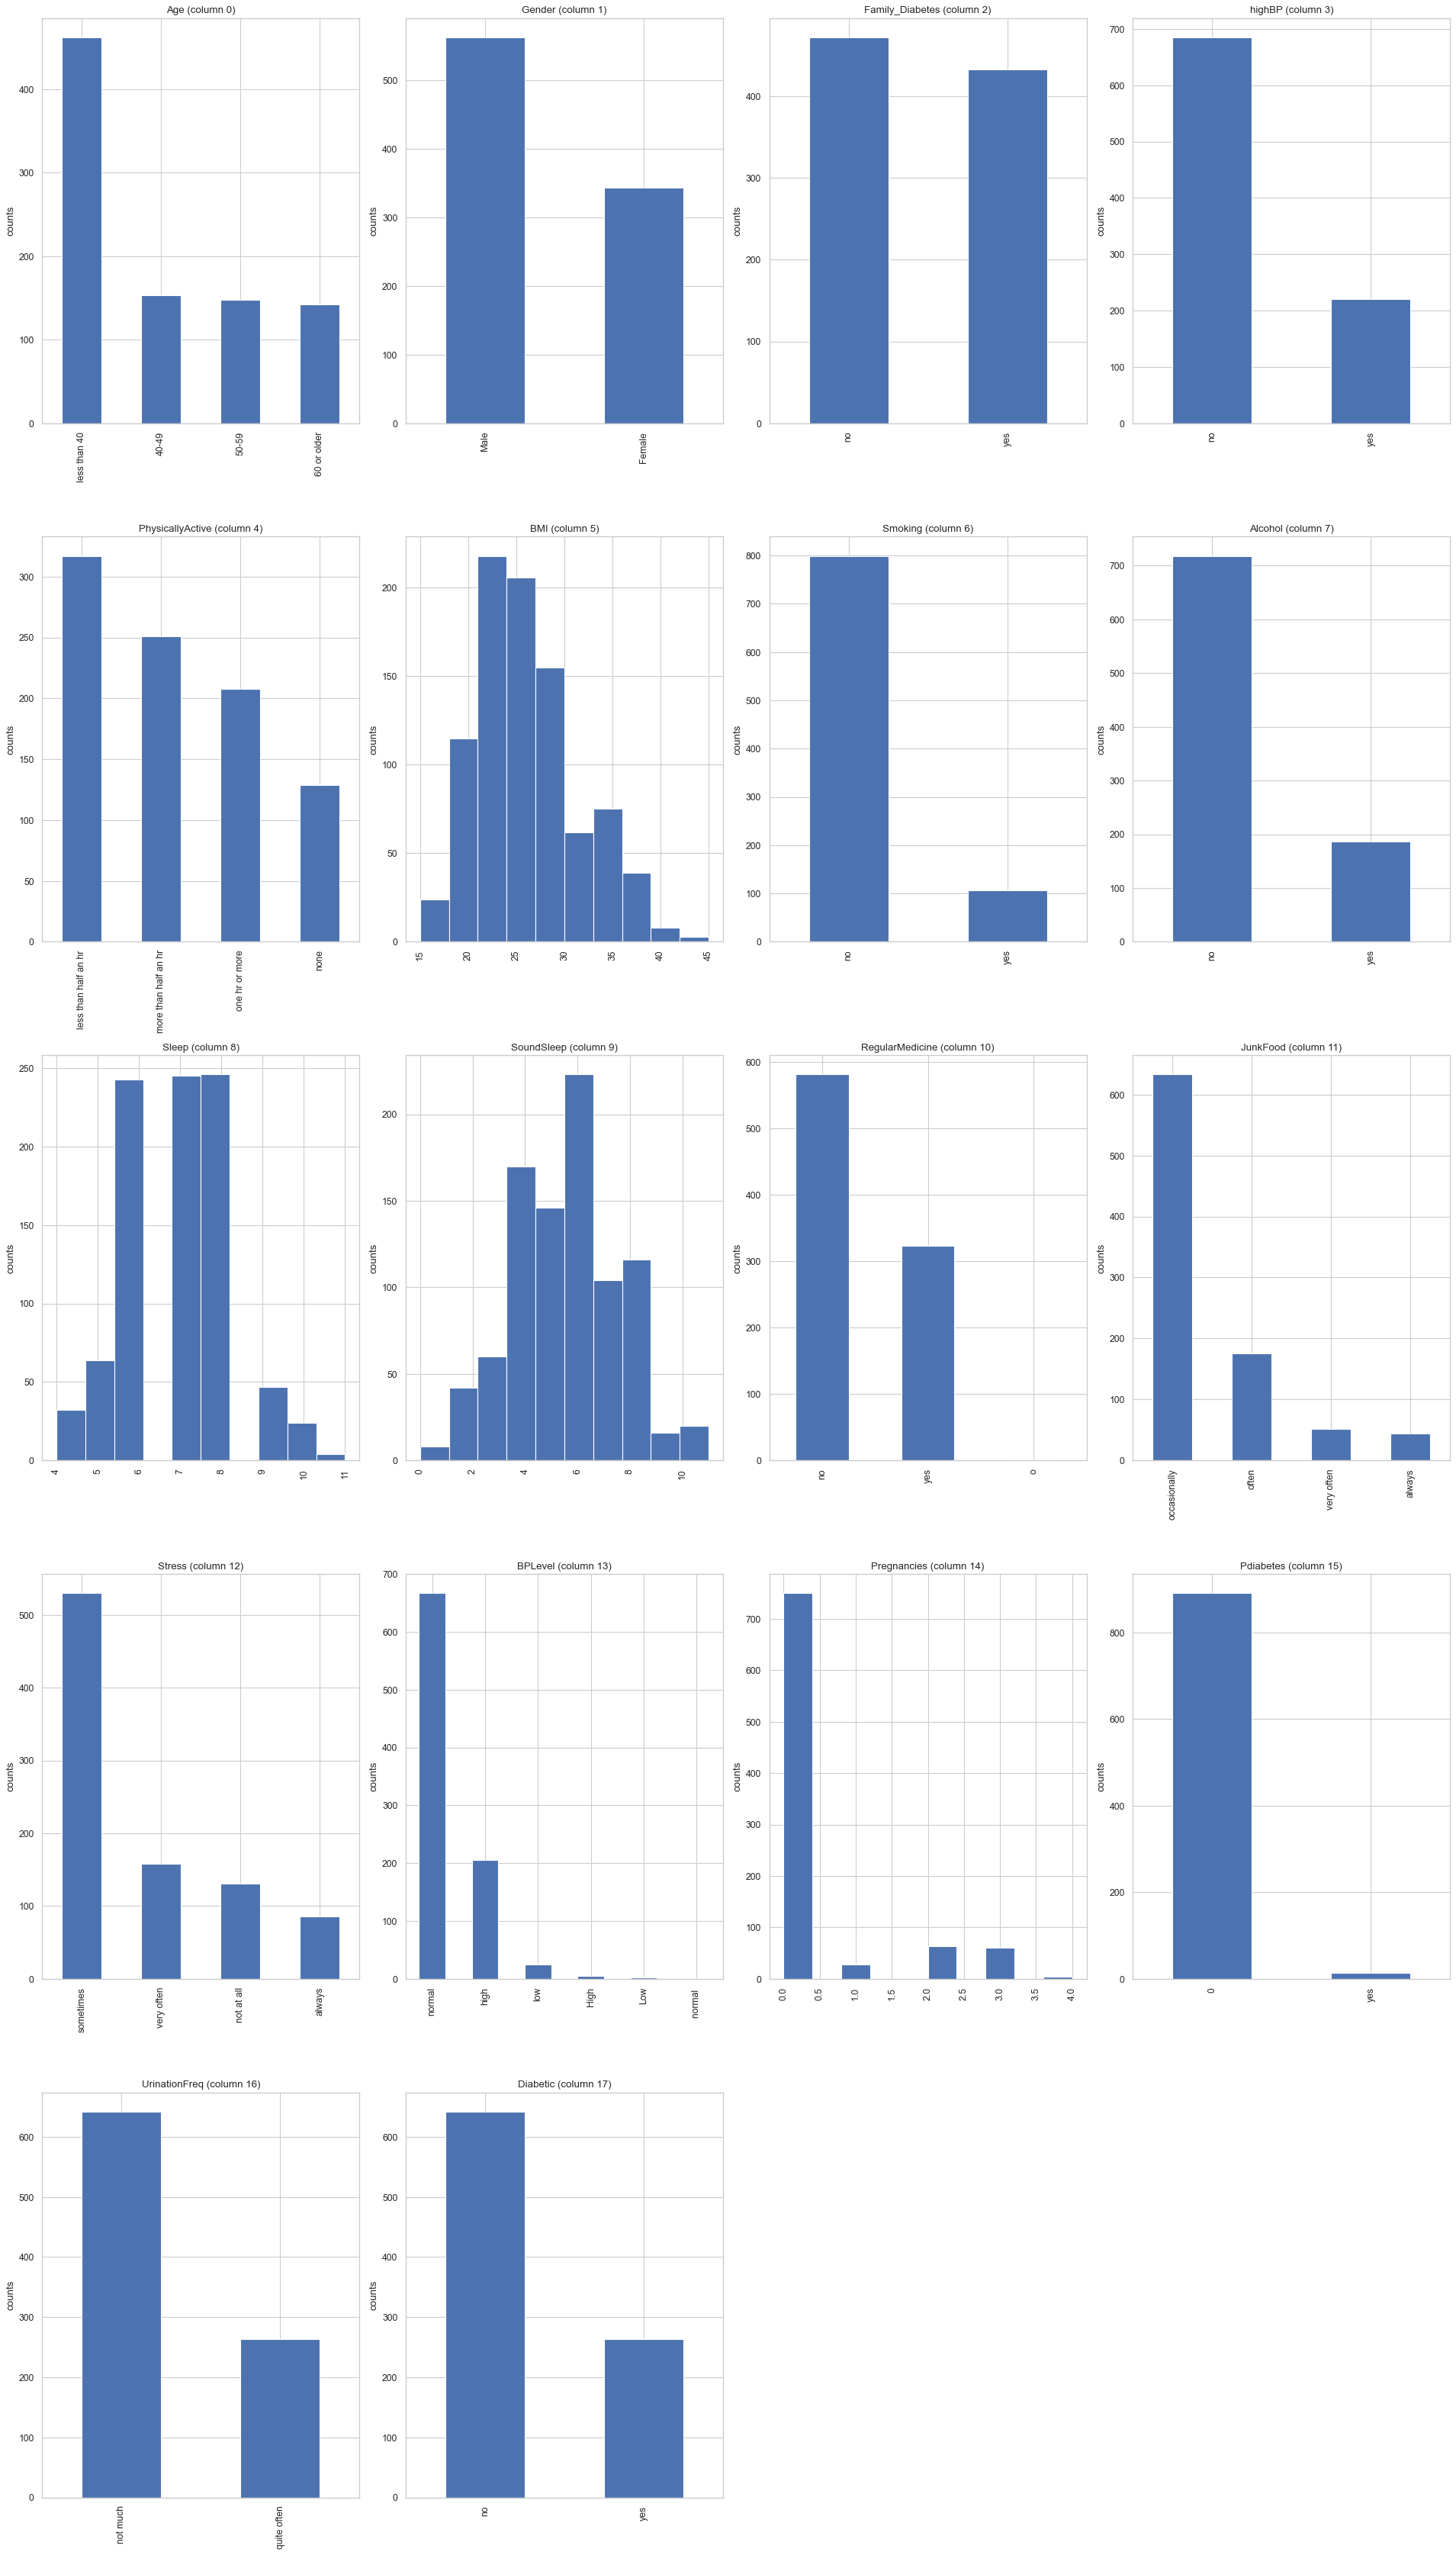

In [17]:
sns.set(style='whitegrid')
plotDistributions(df, 18, 4)

We can see the data distribution for all of our features. Specifically, we recognize: 
- Age: There are much more people under 40. Other groups (40-49, 50-59, 60 or older) are quite balanced. 
- Gender: More male than female participants (around 550 to 330).
- Family_Diabetes: 'no' to 'yes' almost balanced.
- A lot of unbalanced features: highBP, Smoking, Alcohol, Pdiabetes and so on. 
- RegularMedicine: Incorrect recording 'o' instead of 'no'. Will be changed to 'no' since we see in the paper that we should only have yes/no and the 'n' was clearly missing.
- BPLevel: Incorrect recordings due to misspellings ('normal'-'normal ', 'low'-'Low', 'high'-'High')
- Pdiabetes: Incorrect recording '0' instead of 'no'.
- **Diabetic (target variable)**: We clearly have an unbalanced dataset for our target variable 'Diabetic'. Because of that we should think about **balancing our dataset**.

In [18]:
# update column 'RegularMedicine'
df.loc[df['RegularMedicine']=='o', 'RegularMedicine'] = 'no'

# update column 'BPLevel'
df.loc[df['BPLevel']=='normal ', 'BPLevel'] = 'normal'
df.loc[df['BPLevel']=='Low', 'BPLevel'] = 'low'
df.loc[df['BPLevel']=='High', 'BPLevel'] = 'high'

# update column 'Pdiabetes'
df.loc[df['Pdiabetes']=='0', 'Pdiabetes'] = 'no'

# 3) Balancing 
Since we do not have so many entries, we perform oversampling of the data. 
<font color='red'>If we find our models to perform badly we will change this choice afterwards and run again.</font> 

In [19]:
# seperate data from target
y = df['Diabetic']
X = df.drop('Diabetic', axis=1)

# oversample data
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X, y)

In [20]:
# combine data again for further work
df_ros = pd.concat([X_ros, y_ros], axis=1)

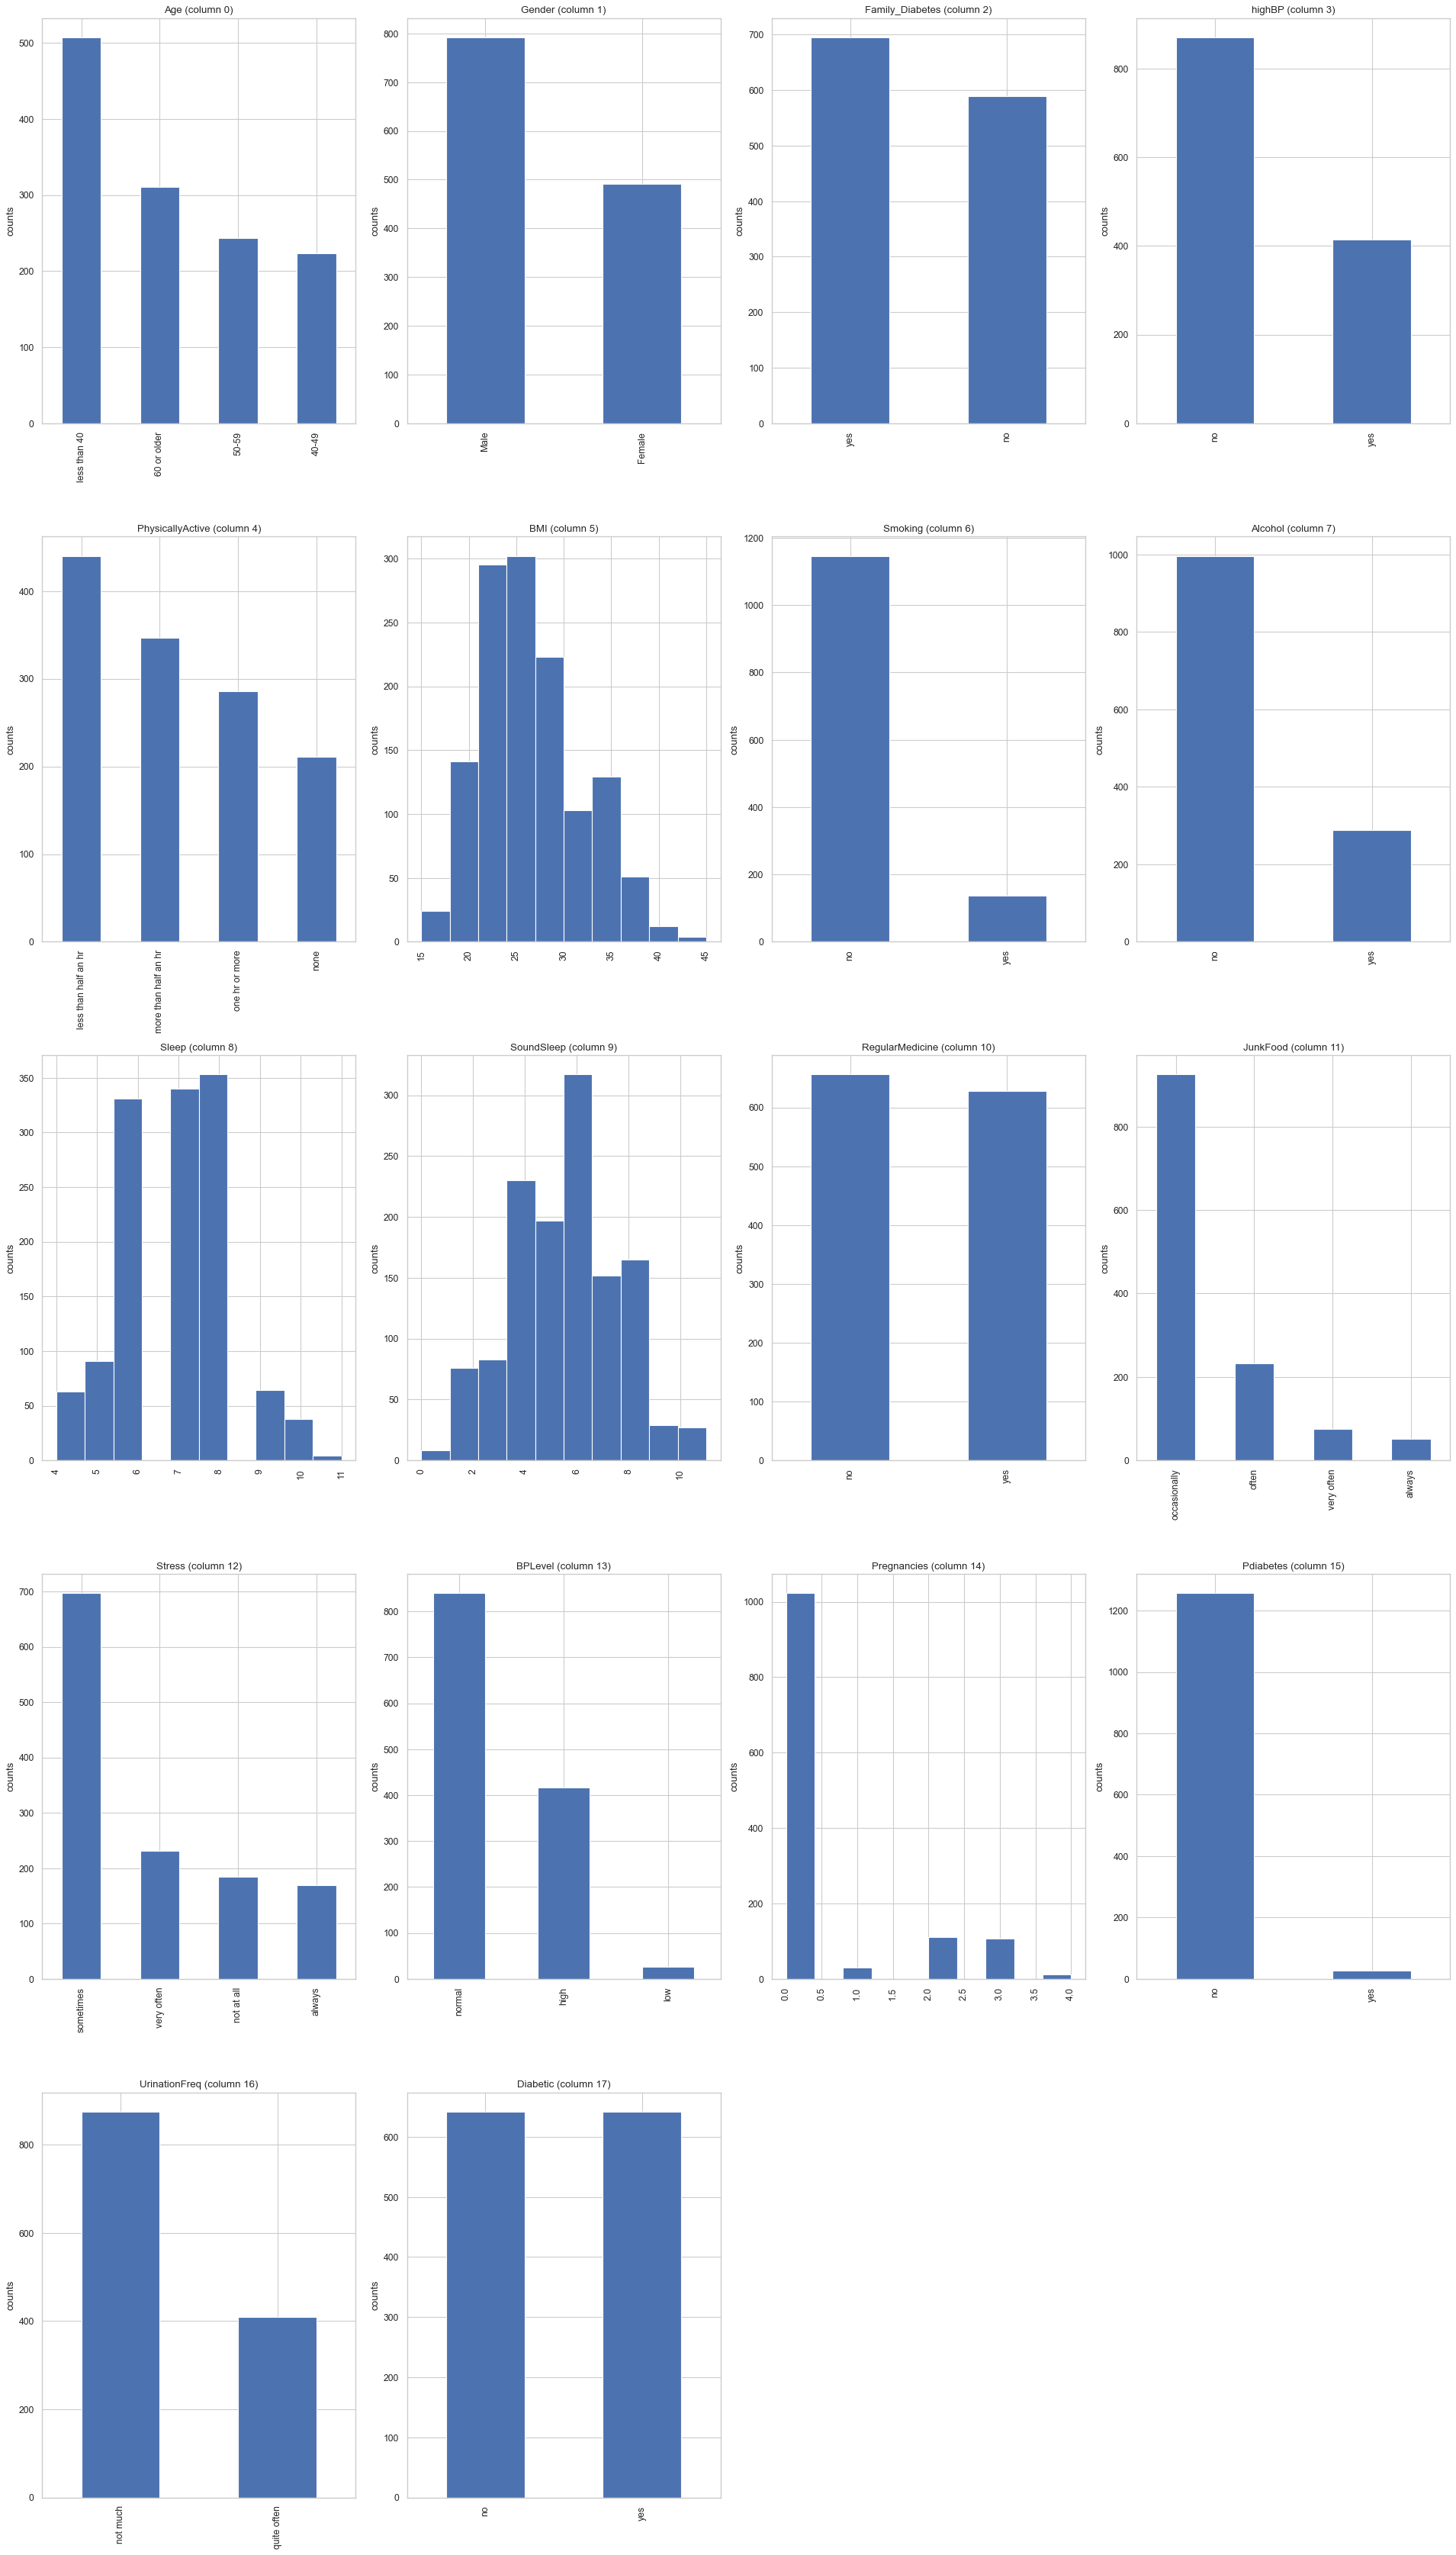

In [21]:
# plot new distributions
plotDistributions(df_ros, 18, 4)

We can see that the oversampling worked well. Let's look at the resulting number of entries after the sampling.

In [22]:
# print main information about data
print("There are {} entries with {} columns including the target variable 'Diabetic'.".format(df_ros.shape[0], df_ros.shape[1]))

There are 1284 entries with 18 columns including the target variable 'Diabetic'.


# 4) Bivariate Analysis
Let's have a closer look at the bivariate analysis meaning the feature distributions dependent on the target variable to see if there are significant patterns we can recognize already just by looking at the data.

In [23]:
def plotDistributionsBivariate(df, nGraphs, nGraphsPerRow):
    nrows, ncols = df.shape
    nGraphRow = (ncols + nGraphsPerRow - 1) / nGraphsPerRow
    plt.figure(num = None, figsize = (6 * nGraphsPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    
    for i in range(min(ncols, nGraphs)):
        plt.subplot(nGraphRow, nGraphsPerRow, i + 1)
        columnDf = df.iloc[:, i]
        
        # check if type in column in object or number
        sns.countplot(x=columnDf,hue='Diabetic',data=df)
            
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{df_header[i]} (column {i})')
        plt.legend(loc='upper right')
        
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

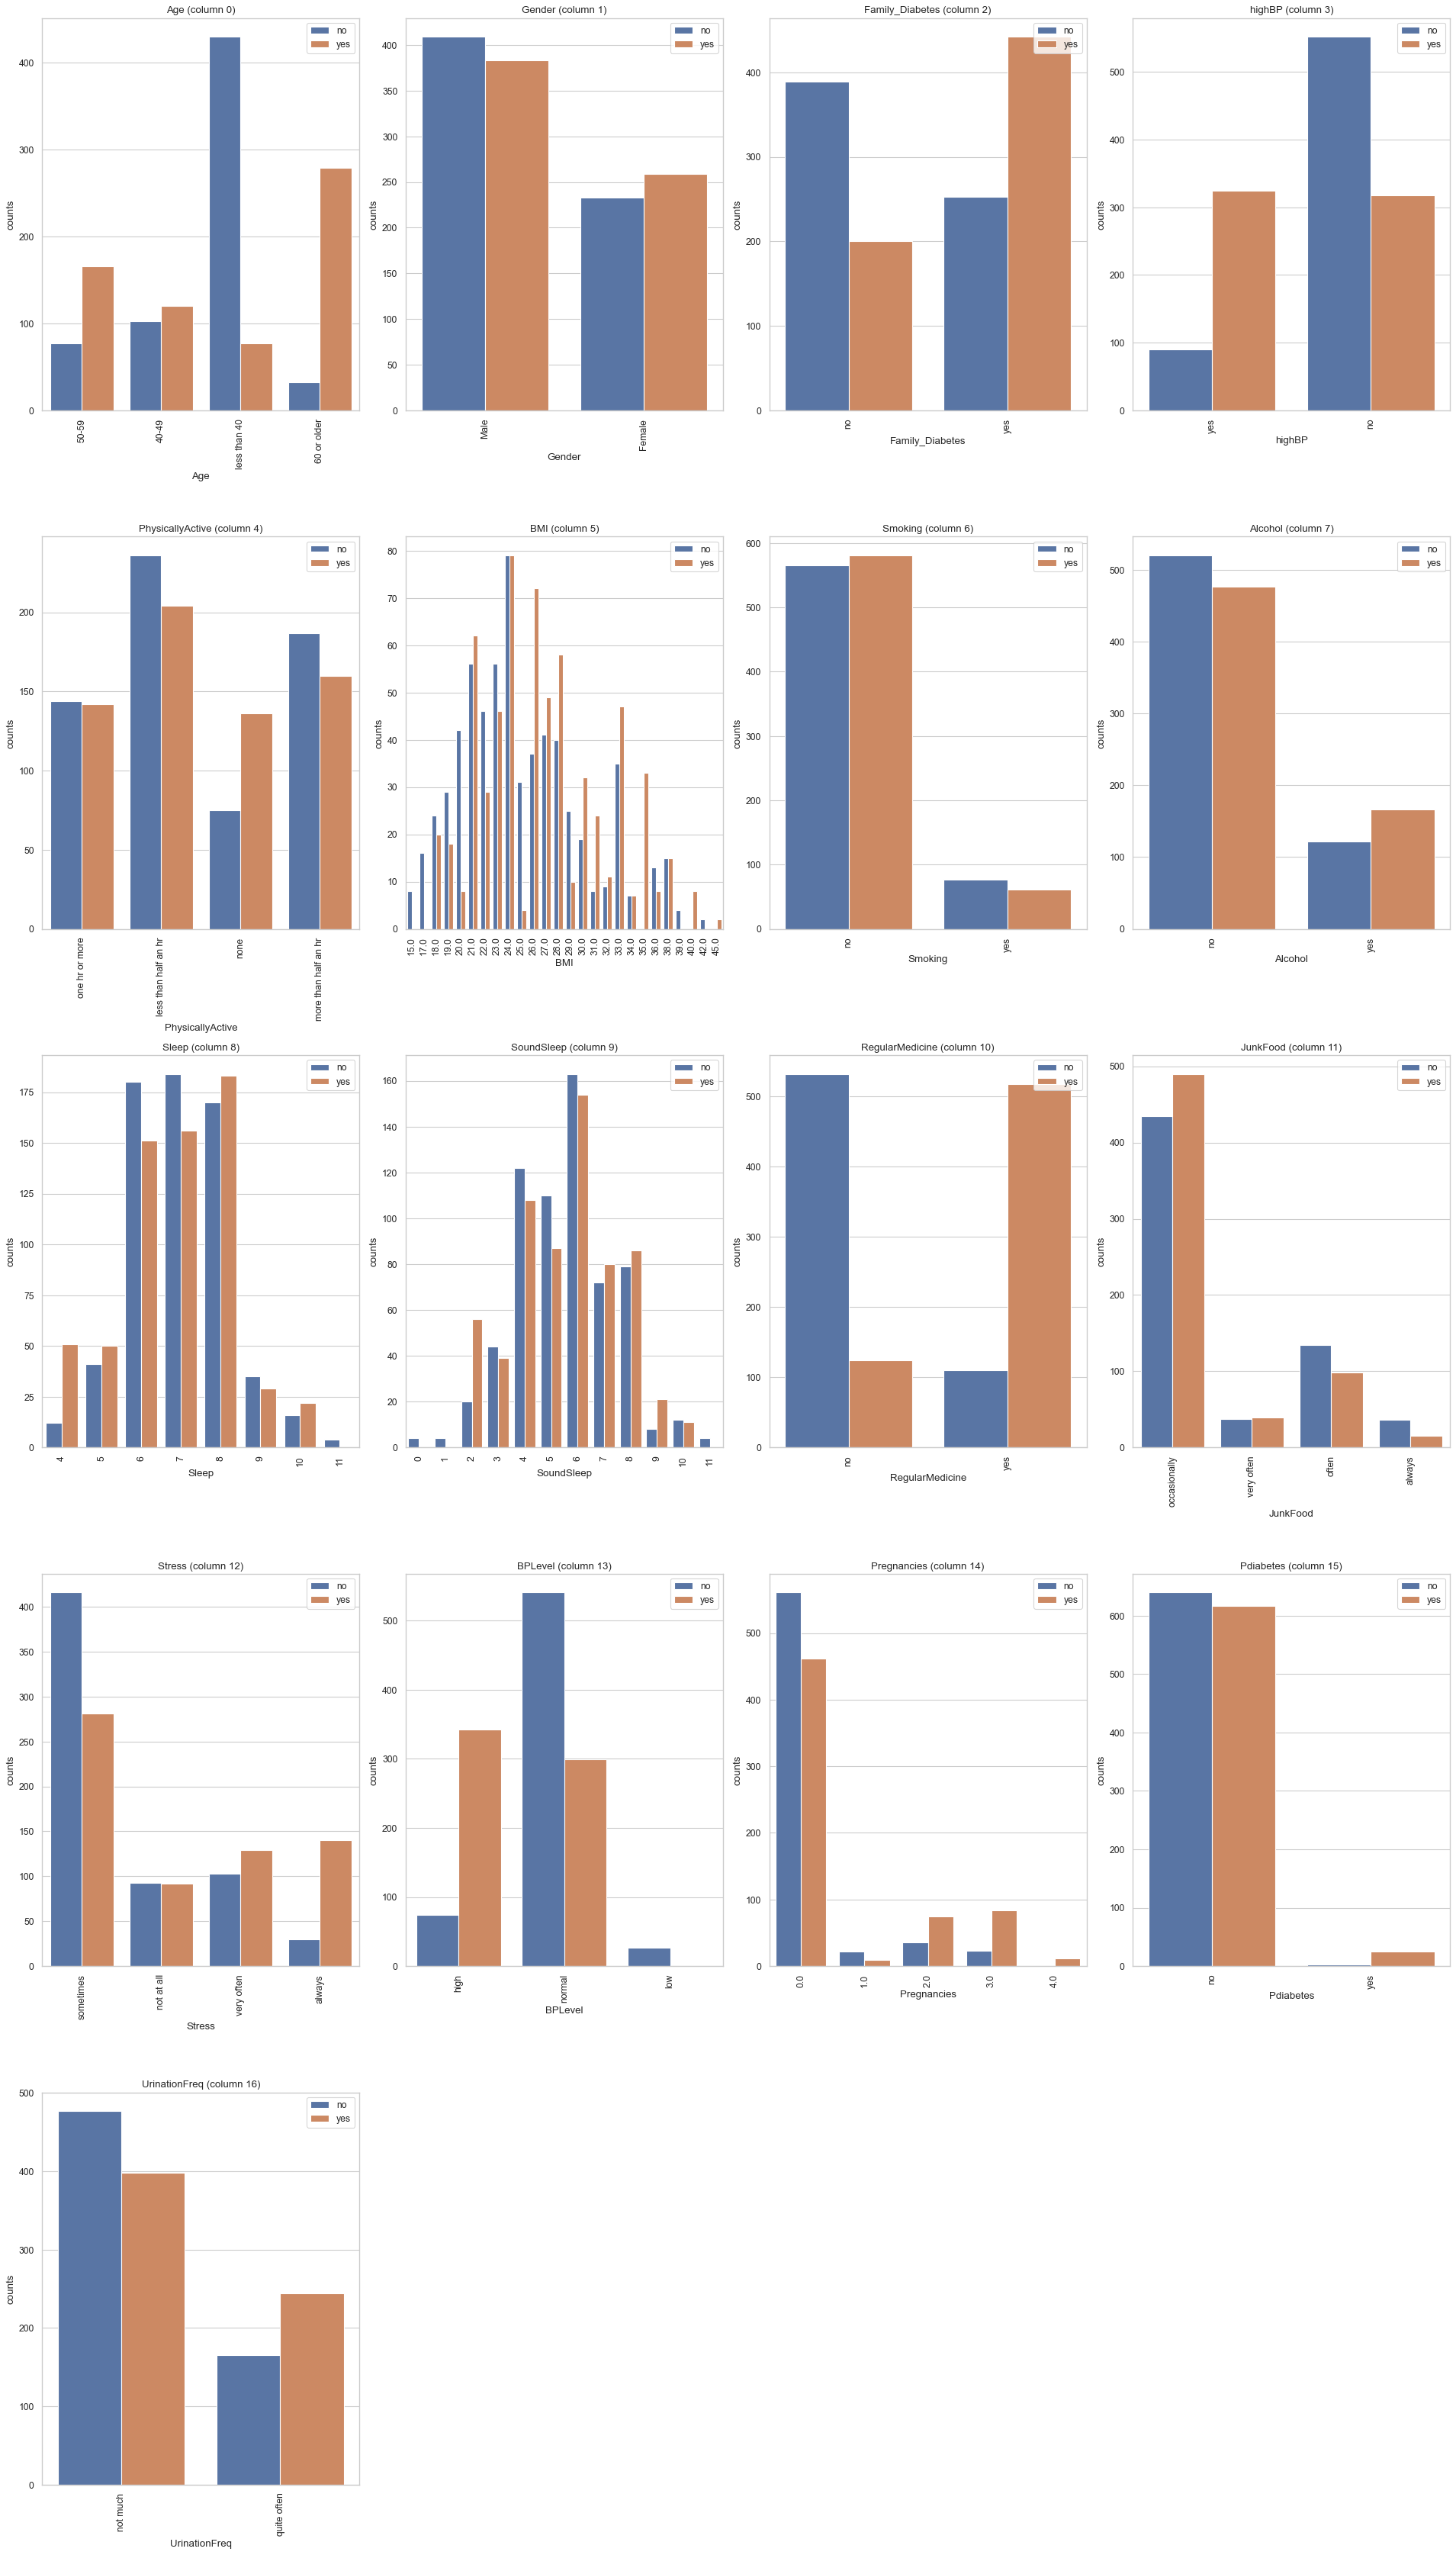

In [24]:
plotDistributionsBivariate(df_ros, 17, 4)

We can already see that some feature distributions differ a lot depending on our target variable Diabetic: 
- Age differs a lot for the 'less than 40' group
- Small differences for Family_Diabetes, highBP, BPLevel
- Huge difference for RegularMedicine
- Others have less significant differences for the Diabetic level in their distribution. 
This analysis should help us for analyzing and understand our models better in the end. But let's first do some feature engineering and have a final look at the feature correlation for all features at the end.

# 5) Actual Feature Creation & Engineering
After balancing, we can now engineer our features such that we can work better with our data in the models. First, we will create new features. After that, we will engineer the existing features as follos: Numerical features shall be scaled with StandardScaler. Categorical features will be one-hot-encoded dropping one column if it is a binary column (since otherwise one column would be unnecessary). Oridnal features like Age, PhysicallyActive, JunkFood, Stress, BPLevel, and UrinationFreq will be encoded using OrdinalEncoder in order to keep the order of the classes helping our Machine Learning models later to pick up the order and make more accurate predictions.
<font color='red'>Scaler used for whole data or do we have to split before?</font> 

From the univariate and bivariate analysis we can see some distinct differences for numerical features at different levels in regards to the target variable. We want to emphasize this by adding some binning features. Since Age is already binned by the original data and we don't have the exact age given, we cannot look at the exact distribution drilled down on a specific age and change the binning here. But maybe we can create new bins for BMI, Sleep, and SoundSleep by first looking at the exact distribution and then select the bins. <font color='red'>We will see after running our models if these newly created features will help learning patterns.</font> 

In [25]:
# define function for distribution overview table in order to find the best bins
def describe_col_dist(df, column):
    dist_df = pd.concat([
    df[column].describe(percentiles = [0.25,0.5,0.75,0.95,0.999]).reset_index().rename(columns={'index': 'Row Type', '{}'.format(column):'Overall {} distribution'.format(column)}),
     df.loc[df['Diabetic']=='yes',['{}'.format(column)]].describe(percentiles = [0.25,0.5,0.75,0.95,0.999]).reset_index(drop = 1).rename(columns={'{}'.format(column):'Diabetic {} distribution'.format(column)}),
     df.loc[df['Diabetic']=='no',['{}'.format(column)]].describe(percentiles = [0.25,0.5,0.75,0.95,0.999]).reset_index(drop = 1).rename(columns={'{}'.format(column):'Non-diabetic {} distribution'.format(column)})], axis=1)
    return dist_df

In [26]:
# for BMI
describe_col_dist(df_ros, 'BMI')

,Row Type,Overall BMI distribution,Diabetic BMI distribution,Non-diabetic BMI distribution
0,count,1284.000000,642.000000,642.000000
1,mean,25.923676,26.842679,25.004673
2,std,5.262295,5.194367,5.172377
3,min,15.000000,18.000000,15.000000
4,25%,22.000000,23.000000,21.000000
5,50%,25.000000,26.000000,24.000000
6,75%,29.000000,30.000000,28.000000
7,95%,36.000000,35.950000,36.000000
8,99.9%,44.151000,45.000000,42.000000
9,max,45.000000,45.000000,42.000000


From this statistical overview and also from the bivariate analysis, we can see that for BMIs after 25 the data distribution changes a lot. Because of this, we implement another column indicating if the BMI is high or not. 

In [27]:
df_ros['BMI_high'] = 0
df_ros.loc[(df_ros['BMI'] > 25), 'BMI_high'] = 1

In [28]:
# for Sleep
describe_col_dist(df_ros, 'Sleep')

,Row Type,Overall Sleep distribution,Diabetic Sleep distribution,Non-diabetic Sleep distribution
0,count,1284.000000,642.000000,642.000000
1,mean,6.929128,6.848910,7.009346
2,std,1.330308,1.419908,1.230111
3,min,4.000000,4.000000,4.000000
4,25%,6.000000,6.000000,6.000000
5,50%,7.000000,7.000000,7.000000
6,75%,8.000000,8.000000,8.000000
7,95%,9.000000,9.000000,9.000000
8,99.9%,11.000000,10.000000,11.000000
9,max,11.000000,10.000000,11.000000


From this statistical overview and also from the bivariate analysis, we can see that there is no significant difference per numerical level that we could use to emphasize the behavior. 

In [29]:
# for SoundSleep
describe_col_dist(df_ros, 'SoundSleep')

,Row Type,Overall SoundSleep distribution,Diabetic SoundSleep distribution,Non-diabetic SoundSleep distribution
0,count,1284.000000,642.000000,642.000000
1,mean,5.553738,5.556075,5.551402
2,std,1.895413,1.946428,1.844503
3,min,0.000000,2.000000,0.000000
4,25%,4.000000,4.000000,4.000000
5,50%,6.000000,6.000000,6.000000
6,75%,7.000000,7.000000,7.000000
7,95%,8.000000,8.000000,8.000000
8,99.9%,11.000000,10.000000,11.000000
9,max,11.000000,10.000000,11.000000


Similarly, for SoundSleep there is no real significance we could take advantage of. Only the first few numbers show a small difference but nothing we could work with. 

Hence, let's move on with the final feature engineering like scaling and encoding.

In [30]:
# define numerical, ordinal, and categorical features
new_features = ['BMI_high']
numerical = ['BMI', 'Sleep', 'SoundSleep', 'Pregnancies']
ordinal = ['Age', 'PhysicallyActive', 'JunkFood', 'Stress', 'BPLevel', 'UrinationFreq']
categorical = list(set(df_header) - set(['Diabetic']) - set(numerical) - set(ordinal))

# specify ordinal rank for ordinal categories
age_order = ['less than 40', '40-49', '50-59', '60 or older']
phys_order = ['none', 'less than half an hr', 'more than half an hr', 'one hr or more']
junkf_order = ['occasionally', 'often', 'very often', 'always']
stress_order = ['not at all', 'sometimes', 'very often', 'always']
bpl_order = ['low', 'normal', 'high']
urin_order = ['not much', 'quite often']

# copy dataframe
X_prep = X_ros.copy()

# encode the target variable into a numeric value
label_enc = preprocessing.LabelEncoder()
y_prep = pd.Series(label_enc.fit_transform(y_ros)).rename('Diabetic')

# encode categorical features with OneHotEncoder
onehot_enc = preprocessing.OneHotEncoder(drop='if_binary')
onehot_encoded = pd.DataFrame(onehot_enc.fit_transform(X_prep[categorical]).toarray(), 
                              columns=onehot_enc.get_feature_names(categorical))
X_prep.drop(columns=categorical, inplace=True)
X_prep = pd.concat([X_prep, onehot_encoded], axis=1)

# encode ordinal features with OrdinalEncoder
ordinal_enc = preprocessing.OrdinalEncoder(categories = [age_order, phys_order, junkf_order, stress_order, bpl_order, 
                                                         urin_order])
X_prep[ordinal] = ordinal_enc.fit_transform(X_prep[ordinal])

# scale numerical features with StandardScaler
scaler = preprocessing.StandardScaler()
X_prep[numerical] = scaler.fit_transform(X_prep[numerical])

# add new features from above and show final preprocessed dataframe
X_prep = pd.concat([X_prep, df_ros[new_features]], axis=1)
X_prep

,Age,PhysicallyActive,BMI,Sleep,SoundSleep,JunkFood,Stress,BPLevel,Pregnancies,UrinationFreq,Gender_Male,Family_Diabetes_yes,Smoking_yes,Pdiabetes_yes,highBP_yes,Alcohol_yes,RegularMedicine_yes,BMI_high
0,2.0,3.0,2.485877,0.805294,0.235535,0.0,1.0,2.0,-0.476208,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,2.0,1.0,0.394720,0.805294,0.235535,2.0,1.0,1.0,-0.476208,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
2,1.0,3.0,-0.365701,-0.698703,0.235535,0.0,1.0,1.0,-0.476208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2.0,3.0,-0.555806,0.805294,0.235535,0.0,1.0,1.0,-0.476208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,1.0,0.204615,0.805294,1.291125,0.0,1.0,1.0,-0.476208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,3.0,2.0,0.204615,-0.698703,-0.292260,0.0,1.0,2.0,-0.476208,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1
1280,3.0,1.0,0.014510,-0.698703,0.235535,0.0,0.0,2.0,-0.476208,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1
1281,1.0,2.0,0.394720,0.805294,0.235535,0.0,3.0,1.0,1.489871,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
1282,2.0,0.0,0.394720,-0.698703,-1.347851,0.0,3.0,2.0,1.489871,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1


In [31]:
# create preprocessed dataset and write to csv file
df_prep = pd.concat([X_prep, pd.DataFrame(y_prep, columns=['Diabetic'])], axis=1)
df_prep.to_csv('data/diabetes_dataset_preprocessed.csv', index=False)

# 6) Feature Correlation
After preprocessing the data, we want to have a look at the final and overall inter-correlations and especially inspect the correlation of features with regards to the target variable 'Diabetic'.

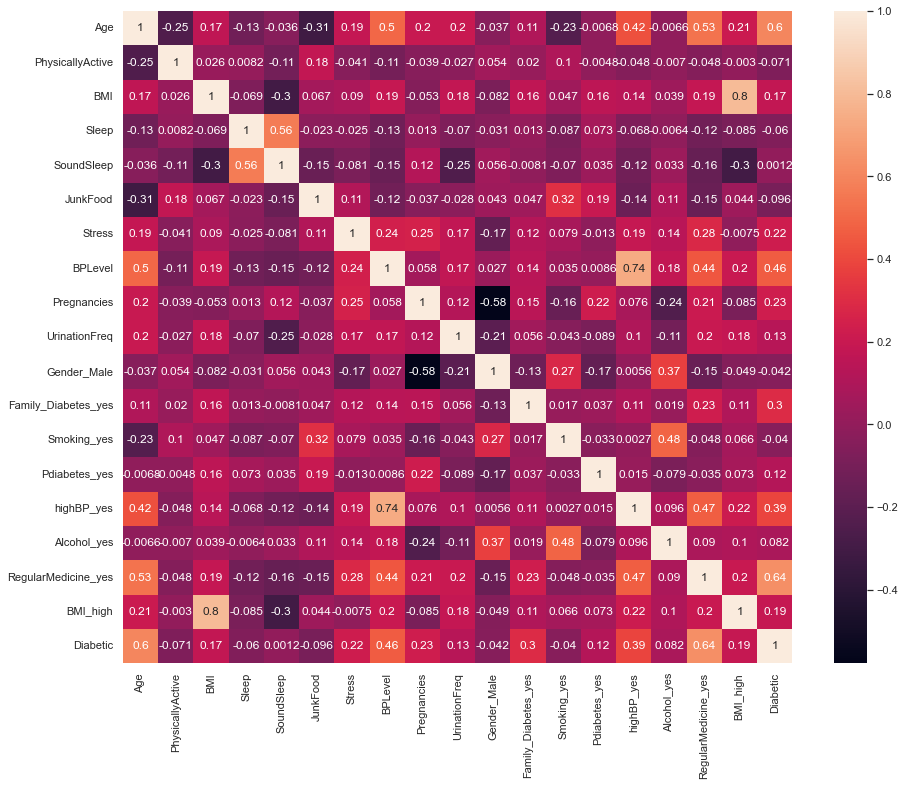

In [32]:
# look at the correlation of the data
plt.figure(figsize=(15,12))
sns.heatmap(df_prep.corr(), annot=True)
plt.show()

Intercorrelation of features: 
- Positive correlation between SoundSleep and Sleep (0.56)
- Small negative correlation between SoundSleep and BMI (-0.3)
- Small negative correlation between JunkFood and Age (-0.31)
- Positive correlation between BPLevel and Age (0.5)
- Negative correlation between Gender_Male and Pregnancies (-0.58; for sure expected)
- Small positive correlation between Smoking_yes and JunkFood (0.32)
- Positive correlation between highBP_yes and Age (0.42)
- Strong positive correlation between highBP_yes and BPLevel (0.74; expected)
- Positive correlation between RegularMedicine_yes and Age (0.53)
- Positive correlation between RegularMedicine_yes and BPLevel (0.44)
- Positive correlation between RegularMedicine_yes and highBP_yes (0.47)
- Small positive correlation between Alcohol_yes and Gender_Male (0.37)
- Positive correlation between Alcohol_yes and Smoking_yes (0.48)
- High postive correlation between BMI_high and BMI (0.8; expected)
- Small negative correlation between BMI_high and SoundSleep (-0.3)

Correlation with the target variable Diabetic:
- Positive with Age (0.6)
- Positive with BPLevel (0.46)
- Positive with highBP_yes (0.39)
- Positive with RegularMedicine_yes (0.64)
- Small positive with Family_Diabetes_yes (0.3)
- Small positive with BMI_high (0.19, so not at our threshold of 0.3 but still to be recognized here since we created the feature on our own; let's see if it helps a bit. The correlation is slightly higher than with BMI)

Only the two further features, BPLevel and highBP_yes, seem to have similar information for our data (similary to BMI and BMI_high). Nonetheless, there is no perfect correlation between the two features and also the correlations with our target variable differ. Because of that, we decide to keep both features in the data.

In general, the features seem to have valuable information for our case. Of course, the full overview of correlations can be seen in the above plot - we only mentioned correlations > |0.3|. 

# 7) Train Test Split
Import our train test data with the function written in our 'Functions' notebook. 

<font color='red'>We have a bit more data due to the oversampling now. Do we want to change the numbers here?</font> Moreover, we set the random state to 42 which will ensure reproducibility of the split.

Loading our training and test data will then look as follows:

In [33]:
X_train, X_test, y_train, y_test = load_train_test_data()

A snippet of our training data:


,Age,PhysicallyActive,BMI,Sleep,SoundSleep,JunkFood,Stress,BPLevel,Pregnancies,UrinationFreq,Gender_Male,Family_Diabetes_yes,Smoking_yes,Pdiabetes_yes,highBP_yes,Alcohol_yes,RegularMedicine_yes,BMI_high
554,0.0,3.0,0.774930,0.053296,-1.347851,0.0,1.0,1.0,-0.476208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
46,2.0,3.0,2.295772,0.805294,0.235535,0.0,2.0,1.0,-0.476208,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1
968,2.0,0.0,0.965035,0.053296,0.235535,0.0,3.0,2.0,-0.476208,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1
816,2.0,2.0,0.204615,0.053296,-0.292260,0.0,1.0,2.0,-0.476208,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1
1120,3.0,2.0,0.014510,0.805294,-1.347851,0.0,1.0,1.0,-0.476208,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1


There are 1091 entries with 18 columns in our training data.
There are 193 entries with 18 columns in our testing data.


With that, our EDA and Preprocessing is done. 